In [99]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np
!pip install folium
import folium 

Apply your credential ID on FourSquare

In [100]:
CLIENT_ID = 'JZIN45G2FBUZFR23ZBP1DRDSGHND0H3ULWYKHL4EEQN5GVRF' # your Foursquare ID
CLIENT_SECRET = 'JFKGLGYLCFYU03MF3IV3DMTITQRCIUXGRXTHFAEXVZW2DLYL' # your Foursquare Secret
VERSION = '20210211'
LIMIT = 40
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JZIN45G2FBUZFR23ZBP1DRDSGHND0H3ULWYKHL4EEQN5GVRF
CLIENT_SECRET:JFKGLGYLCFYU03MF3IV3DMTITQRCIUXGRXTHFAEXVZW2DLYL


In [101]:
request_parameters = {
    "client_id": CLIENT_ID,
    "client_secret": CLIENT_SECRET,
    "v": VERSION,
    "section": "Restaurantes",
    "near": "Lisboa",
    "radius": 1000,
    "limit": 1000}


data = requests.get("https://api.foursquare.com/v2/venues/explore", params=request_parameters).json()
#print(data)

Import our results into a panda dataframe and remove some extra columns

In [102]:
venues = data['response']['groups'][0]['items']

pd.set_option('display.max_colwidth', None)
from pandas import json_normalize
restaurants = json_normalize(venues)

del restaurants['referralId']
del restaurants['reasons.count']
del restaurants['reasons.items']
del restaurants['venue.id']
del restaurants['venue.categories']
del restaurants['venue.venuePage.id']
del restaurants['venue.location.crossStreet']
del restaurants['venue.photos.groups']
del restaurants['venue.location.labeledLatLngs']

restaurants.head()


,venue.name,venue.location.address,venue.location.lat,venue.location.lng,venue.location.postalCode,venue.location.cc,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.photos.count,venue.location.neighborhood
0,Miradouro Sophia de Mello Breyner Andresen,Largo da Graça,38.716454,-9.131557,1170-165,PT,Lisboa,Lisboa,Portugal,"[Largo da Graça, 1170-165 Lisboa, Portugal]",0,NaN
1,Café da Garagem,"Rua da Costa do Castelo, 75",38.714806,-9.132889,1100,PT,Lisboa,Lisboa,Portugal,"[Rua da Costa do Castelo, 75, 1100 Lisboa, Portugal]",0,Santa Maria Maior
2,Jardim da Cerca da Graça,NaN,38.717911,-9.132196,NaN,PT,Lisboa,Lisboa,Portugal,"[Lisboa, Portugal]",0,NaN
3,Miradouro da Senhora do Monte,R. Senhora do Monte,38.719072,-9.132793,1170-254,PT,Lisboa,Lisboa,Portugal,"[R. Senhora do Monte, 1170-254 Lisboa, Portugal]",0,Centro Histórico
4,The Food Temple,"Beco do Jasmim, 18",38.715881,-9.134385,1100-289,PT,Lisboa,Lisboa,Portugal,"[Beco do Jasmim, 18, 1100-289 Lisboa, Portugal]",0,NaN


Lets see some stats about our restaurants list

In [122]:
restaurants.count()

venue.name                         100
venue.location.address              89
venue.location.lat                 100
venue.location.lng                 100
venue.location.postalCode           62
venue.location.cc                  100
venue.location.city                 95
venue.location.state                95
venue.location.country             100
venue.location.formattedAddress    100
venue.photos.count                 100
venue.location.neighborhood         14
cluster_label                      100
dtype: int64

We sse there are some lines with empty Postal Code
We drop all lines with empty Postal Code

In [104]:
restaurants.dropna(subset=['venue.location.postalCode'], inplace=True)
restaurants.count()

plot our restaurants in a map

In [105]:
from folium import plugins

map_Lisbonne = folium.Map(location=[38.736946,-9.142685], zoom_start=13)

def add_markers(df):
    for (j, row) in df.iterrows():
        label = folium.Popup(row["venue.name"], parse_html=True)
        folium.CircleMarker(
            [row["venue.location.lng"], row["venue.location.lat"]],
            radius=5,
            popup=label,
            color='red',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_Lisbonne)

add_markers(restaurants);
hm_data = restaurants[["venue.location.lat", "venue.location.lng"]].to_numpy().tolist()
map_Lisbonne.add_child(plugins.HeatMap(hm_data))

map_Lisbonne

Next we will create a dataframe that will group the restaurants by postal code

In [106]:
# Lets check how many restaurants were returned for each postal code
# restaurantesPostalCode = restaurants.groupby("venue.location.postalCode", as_index=False).count()
# restaurantesPostalCode = restaurants.groupby("venue.location.postalCode", as_index=False).sum().reset_index()
# restaurantesPostalCode.head()


Now we need to cluster all the restaurants into different clusters.

Using KMeans we have to find correct k, number of clusters, it's not easy to find the correct number clusters, for this we will use the elbow method, the idea is to run kmeans trhu the dataset n times, and for each value calculate the Sum of Square Errors, by plotting this in a graph we can see that at at the optimum K the graph stabilizes and there is no improvement. 


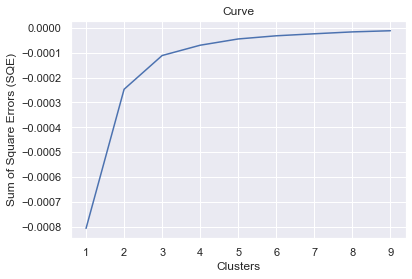

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv

K = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K]
Y_axis = restaurants[['venue.location.lat']]
X_axis = restaurants[['venue.location.lng']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Plot
plt.plot(K, score)
plt.xlabel('Clusters')
plt.ylabel('Sum of Square Errors (SQE)')
plt.title('Curve')
plt.show()

Lets add the gps cordinates for each postal code 

the graph clearly state that the optimum value is 3

In [116]:
restaurants.columns[2:4]

Index(['venue.location.lat', 'venue.location.lng'], dtype='object')

In [119]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(restaurants[restaurants.columns[2:4]]) # k-means clustering Compute 
restaurants['cluster_label'] = kmeans.fit_predict(restaurants[restaurants.columns[2:4]])
centers = kmeans.cluster_centers_ # cluster centers Coordinates
labels = kmeans.predict(restaurants[restaurants.columns[2:4]]) # Labels
restaurants

,venue.name,venue.location.address,venue.location.lat,venue.location.lng,venue.location.postalCode,venue.location.cc,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.photos.count,venue.location.neighborhood,cluster_label
0,Miradouro Sophia de Mello Breyner Andresen,Largo da Graça,38.716454,-9.131557,1170-165,PT,Lisboa,Lisboa,Portugal,"[Largo da Graça, 1170-165 Lisboa, Portugal]",0,NaN,0
1,Café da Garagem,"Rua da Costa do Castelo, 75",38.714806,-9.132889,1100,PT,Lisboa,Lisboa,Portugal,"[Rua da Costa do Castelo, 75, 1100 Lisboa, Portugal]",0,Santa Maria Maior,0
2,Jardim da Cerca da Graça,NaN,38.717911,-9.132196,NaN,PT,Lisboa,Lisboa,Portugal,"[Lisboa, Portugal]",0,NaN,0
3,Miradouro da Senhora do Monte,R. Senhora do Monte,38.719072,-9.132793,1170-254,PT,Lisboa,Lisboa,Portugal,"[R. Senhora do Monte, 1170-254 Lisboa, Portugal]",0,Centro Histórico,0
4,The Food Temple,"Beco do Jasmim, 18",38.715881,-9.134385,1100-289,PT,Lisboa,Lisboa,Portugal,"[Beco do Jasmim, 18, 1100-289 Lisboa, Portugal]",0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Amorino,"R. Augusta, 209",38.711807,-9.138144,1100-051,PT,Lisboa,Lisboa,Portugal,"[R. Augusta, 209, 1100-051 Lisboa, Portugal]",0,NaN,1
96,Memmo Alfama,"Travessa das Merceeiras, 27",38.710304,-9.130199,1100-348,PT,Lisboa,Lisboa,Portugal,"[Travessa das Merceeiras, 27 (Alfama), 1100-348 Lisboa, Portugal]",0,NaN,2
97,Luvaria Ulisses,Rua do Carmo 87 A,38.712307,-9.139592,1900-302,PT,Lisboa,Lisboa,Portugal,"[Rua do Carmo 87 A, 1900-302 Lisboa, Portugal]",0,NaN,1
98,A Padaria Portuguesa,"Av. Alm. Reis 29-A, 1150-008 Lisboa",38.722583,-9.135278,1150-008,PT,Lisboa,Lisboa,Portugal,"[Av. Alm. Reis 29-A, 1150-008 Lisboa, 1150-008 Lisboa, Portugal]",0,Anjos,0


Visualize the cluster

Visualize the cluster by plotting the data colored by these labels. The cluster center are from the kmean 

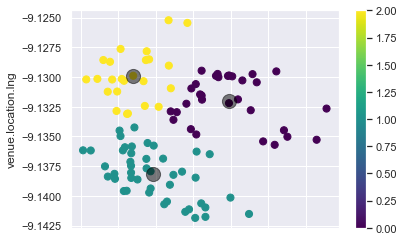

In [121]:
restaurants.plot.scatter(x = 'venue.location.lat', y = 'venue.location.lng', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)